In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.linalg
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import rbf_kernel

In [2]:
from data_handling import LaserDataInteractorESRF
import data_processing 

## Collapse data

In [3]:
path_rel = '/Volumes/Sandisk_SD/Work/IZFP/Laser/03_ESRF/Code/measurements/ESRF_TU_Ilmenau_IZFP/Messdaten_QASS'
fs_HD = 20*10**3 #[hz]
collapse = np.loadtxt(f'{path_rel}/999_collapse/collapse.txt')/fs_HD

## AE data

In [4]:
# Known measurmeent variables
fs = 6.25* 10**6 #[Hz]
dt = 1/fs #[s]

# Data info
chNo = 1
fileNo = 50
path_rel = '/Volumes/Sandisk_SD/Work/IZFP/Laser/03_ESRF/Code/measurements/ESRF_TU_Ilmenau_IZFP/Messdaten_QASS'

In [5]:
# --- Raw data
interactor = LaserDataInteractorESRF()
interactor.path_rel = path_rel
# Ch.1
interactor.fname = (1, fileNo) # ChNo, fileNo
sig1, dt1 = interactor.load_data(ret_dt=True)
sig1 -= sig1.mean()
# Ch.2
interactor.fname = (2, fileNo) # ChNo, fileNo
sig2, dt2 = interactor.load_data(ret_dt=True)
sig2 -= sig2.mean()

print(f'dt={dt*10**6}, dt1={dt*10**6}, dt2={dt2*10**6}')
del dt1, dt2

dt=0.16, dt1=0.16, dt2=0.1599975016655563


In [6]:
# --- Data processing
# ---- Parameters: -> based on the spectrogram --> then, we can downsample by 3
fmin = 200*10**3 # [Hz]
fmax = 300*10**3 # [Hz] 
# Downsample in freq. domain
ds = 3 # downsample factor

# ---- Processing: Bandpass + down sampling
def bpds(_sig):
    processor = data_processing.ProcessingUtil()
    _sig_bp = processor.apply_bandpass(_sig, f_range=[fmin, fmax], dt=dt)
    _sig_processed = processor.downsample(_sig_bp, ds, ret_freps=False)
    # Unit energy
    energy = np.sum(_sig_processed**2)
    return _sig_processed/np.sqrt(energy)
    
# Ch.1
sig1_proc = bpds(sig1)
# Ch.2
sig2_proc = bpds(sig2)

fs_new = round(fs/ds, 9)
dt_new = round(1/fs_new, 9)

## Data set preparation: AE signals

In [7]:
def segment_AE_signal(_sig, _t_start, _t_end, _T, _dt, ret_t=False):
    # (1) Array size
    n = int(_T/_dt) # = number of time samples within _T (i.e. per segment)
    # (2) segment points 
    # ---> needs to be calculated based on indices, otherwise a quantization error causes inconsistent interval between indices
    # !!! indices[-1] = the last bin edges, i.e. the point we need to exclude (this is useful to compute bin edges for collapse though)
    indices = np.arange(int(_t_start/_dt), int((_t_end+_T)/_dt), n)
    # (3) Segmenting: there is a function for slicing and reshaping in numpy!
    # This stride_tricks.sliding_window_view works exactly what I want: 
    # (3.1) array start corresponds to the given index of the input (here _sig)
    # (3.2) slices the input with the constant length (here n)
    arr = np.lib.stride_tricks.sliding_window_view(_sig, n)[indices[:-1], :]
    # (4) Unit energy for each segment ---> may be better for constructing the similarity matrix?
    arr = arr - arr.mean(axis=1, keepdims=True)
    arr = arr / np.linalg.norm(arr, axis=1, keepdims=True)
    # Sanity check
    print(f'Sanity check: last collapse = {_t_end}s, last window = {indices[-2]*_dt}...{indices[-2]*_dt+_T}')
    print(f'Segemented array equal? {np.array_equal(arr[0, :], _sig[indices[0]:indices[1]])}')
    if ret_t == False:
        return arr.T
    else:
        t = np.around(_dt* indices, 9)
        return arr.T, t
    
# Params for segmenting
# ---> Weld starting point
t_start_HD = 0.2154 #[s]
t_start_qass = 0.017#0.017, 0.02677: from data, either t_start_qass = 0.017, or t_start_qass = 0.02677
t_offset = t_start_HD - t_start_qass # [s], determined "by eyes" 
collapse_qass = np.around(collapse - t_offset, 9)
# ---> Window duration
T = 0.025 # [s]

X1, t = segment_AE_signal(sig1_proc, t_start_qass, collapse_qass[-1], T, dt_new, ret_t=True)
X2 = segment_AE_signal(sig2_proc, t_start_qass, collapse_qass[-1], T, dt_new)
# Combine
X = np.concatenate((X1, X2), axis=-1)
print(X.shape)
print(t) #-> which we need for computing the collapse density

del sig1, sig2, sig1_proc, sig2_proc

Sanity check: last collapse = 0.31485s, last window = 0.29199791999999997...0.31699792
Segemented array equal? False
Sanity check: last collapse = 0.31485s, last window = 0.29199791999999997...0.31699792
Segemented array equal? False
(52083, 24)
[0.01699968 0.04199952 0.06699936 0.0919992  0.11699904 0.14199888
 0.16699872 0.19199856 0.2169984  0.24199824 0.26699808 0.29199792
 0.31699776]


In [9]:
import plotly.graph_objects as go

run_plotly = False

if run_plotly == True:
    X = X1
    # Create the figure
    fig = go.Figure()
    
    n = X.shape[0]
    M = X.shape[1]
    
    # Add each signal as a trace
    for i in range(M):
        fig.add_trace(go.Scatter(
            x=np.arange(n), 
            y=X[:, i], 
            mode='lines', 
            name=f"Signal {i+1}", 
            visible=True
        ))
    
    # Update layout for better interactivity
    fig.update_layout(
        title="Interactive Signal Plot",
        xaxis_title="Time",
        yaxis_title="Amplitude",
        legend_title="Signals",
        updatemenus=[
            {
                "buttons": [
                    {"label": "Show All", "method": "update", "args": [{"visible": [True] * M}]} 
                ] + [
                    {"label": f"Show Signal {i+1}", "method": "update",
                     "args": [{"visible": [j == i for j in range(M)]}]} 
                    for i in range(M)
                ],
                "direction": "down",
                "showactive": True,
            }
        ]
    )
    
    # Show figure
    fig.show()


## Dataset preparation: collapse (i.e. labels)

NameError: name 'labels' is not defined

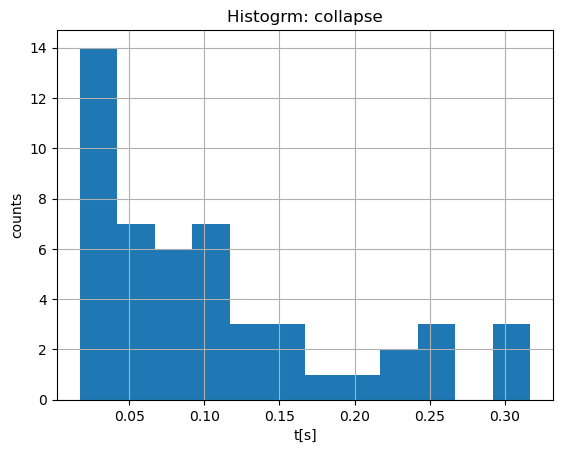

In [8]:
# Histrogram
counts, _ = np.histogram(collapse_qass, bins=t)
plt.bar(x=t[:-1], height=counts, align='edge', width=t[1]-t[0])
plt.title('Histogrm: collapse')
plt.xlabel('t[s]')
plt.ylabel('counts')
plt.grid(True)
print(labels)

## Graph-based analysis

In [ ]:
def unnormalized_spectral_clustering(X, k, sigma=1.0):
    """
    Perform unnormalized spectral clustering.

    Parameters:
    X : ndarray of shape (n_samples, n_features)
        Input data.
    k : int
        Number of clusters.
    sigma : float, optional (default=1.0)
        Parameter for the RBF kernel.

    Returns:
    labels : ndarray of shape (n_samples,)
        Cluster labels for each point.
    """
    # Step 1: Compute the similarity matrix using the RBF kernel
    W = rbf_kernel(X, gamma=1.0 / (2 * sigma**2))

    # Step 2: Compute the degree matrix
    D = np.diag(W.sum(axis=1))

    # Step 3: Compute the unnormalized graph Laplacian
    L = D - W

    # Step 4: Compute the first k eigenvectors of L
    eigvals, eigvecs = scipy.linalg.eigh(L, subset_by_index=[0, k-1])

    # Step 5: Construct the matrix U
    U = eigvecs

    # Step 6: Normalize row-wise (not needed for unnormalized spectral clustering)

    # Step 7: Apply k-means to the rows of U
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=0)
    labels = kmeans.fit_predict(U)

    return labels

In [9]:
# (1) Adjacency / weight matrix using the RBF kernel
sigma=0.2
W = rbf_kernel(X1.T, gamma=1.0 / (2 * sigma**2))
print(W.shape)
# Step 2: Compute the degree matrix
D = np.diag(W.sum(axis=1))
# Step 3: Compute the unnormalized graph Laplacian
L = D - W
# Step 4: Compute the first k eigenvectors of L
eigvals, eigvecs = scipy.linalg.eigh(L)

(12, 12)


[3.24884530e-17 1.48279385e-10 1.51005304e-10 1.65865958e-10
 1.74378881e-10 1.87338859e-10 1.95546870e-10 2.08519463e-10
 2.22810012e-10 2.29501545e-10 2.45308444e-10 2.52669337e-10]


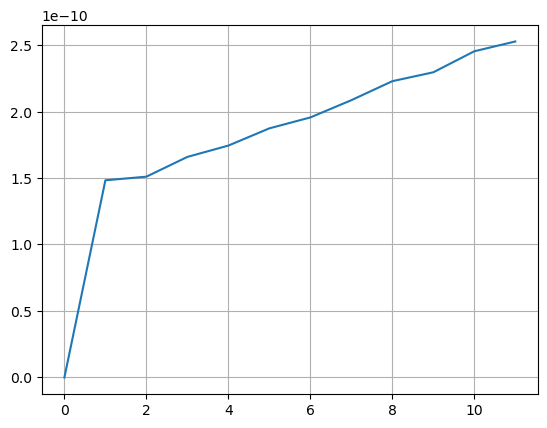

In [10]:
print(eigvals)
plt.plot(eigvals)
plt.grid(True)

In [14]:
# Step 5: Construct the matrix U
k = 3 # determined based on eigenvalue analysis
U = eigvecs[:, :k]
# Step 7: Apply k-means to the rows of U
kmeans = KMeans(n_clusters=k, n_init=10, random_state=0)
labels = kmeans.fit_predict(U)

In [15]:
print(f'Collapse density = {counts}')
print(f'Predicted labels = {labels}')

Collapse density = [14  7  6  7  3  3  1  1  2  3  0  3]
Predicted labels = [1 0 1 0 1 2 0 0 1 0 1 1]


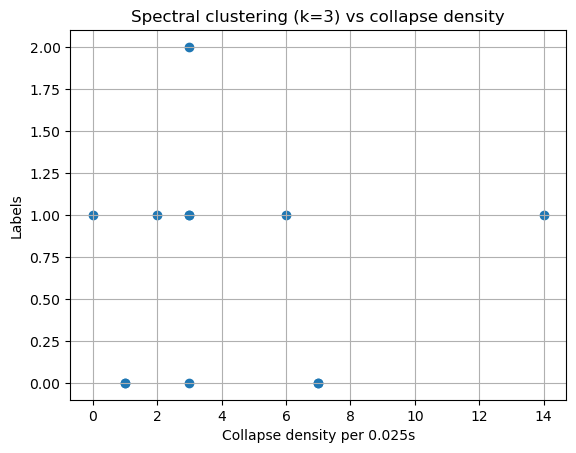

In [16]:
plt.scatter(counts, labels)
plt.grid(True)
plt.title(f'Spectral clustering (k={k}) vs collapse density')
plt.xlabel(f'Collapse density per {T}s')
plt.ylabel('Labels')
plt.show()